In [21]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, MultiHeadAttention, Embedding, Add, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
import bisect
import re
import math
import os

## Use a bigger dataset: (n_tokens ~~ 2 * n_params)

In [22]:
"""
# My tokenkization
from nltk.corpus import brown

for file in brown.fileids():
    clean_file = re.sub(r'/[^\s]+', ' ', brown.raw(file))
    dataset += clean_file + "\n" # Concatenate all the files together

dataset = re.sub(r'\s+', ' ', dataset)
len(dataset) # Number of characters
"""

'\n# My tokenkization\nfrom nltk.corpus import brown\n\nfor file in brown.fileids():\n    clean_file = re.sub(r\'/[^\\s]+\', \' \', brown.raw(file))\n    dataset += clean_file + "\n" # Concatenate all the files together\n\ndataset = re.sub(r\'\\s+\', \' \', dataset)\nlen(dataset) # Number of characters\n'

In [23]:
import pandas as pd
dataset = ""

texts = pd.read_csv('/kaggle/input/brown.csv')["tokenized_text"]
for text in texts:
    dataset += text
# Separate the punctuation from the words by a space
dataset = re.sub('[^a-zA-Z0-9\s]+', lambda x: x.group(0)[0] , dataset)    
dataset = re.sub(r'\s+', ' ', dataset)

dataset = dataset.split()

In [24]:
vocab = sorted(set(dataset))
vocab_size = len(vocab) + 2
vocab_size

61264

In [25]:
sentences = " ".join(dataset).split(".")
sentences = [s.split() for s in sentences if len(s.split())>0]
max_length = max([len(s) for s in sentences])
max_length

830

In [26]:
lengths = [len(s) for s in sentences]
print(np.mean(lengths), np.std(lengths), np.quantile(lengths, .999))

# 1 in 1000 sentences exceeds 128 so 128 it is.

19.899629529231046 15.372308871704446 118.66599999999744


In [41]:
n_tokens = sum(lengths)
n_tokens
# 100-200x this number

1101146

In [27]:
sentence_length = 128 # 2 ** math.ceil(math.log2(max_length)) if we want to
# include every sentence. But truncating 1 in 1000 for 8x memory saving seems
# obvious.
pad_id = 0
start_id = 1

point = bisect.bisect_left(vocab, '.') + 2
dataset = np.zeros((len(sentences),  sentence_length + 1), dtype = np.float32) + pad_id

for i, sentence in enumerate(sentences):
    dataset[i, :min(len(sentence) + 2, sentence_length + 1)] = np.array([start_id] + [bisect.bisect_left(vocab, word) + 2 for word in sentence][:sentence_length - 1] + [point], dtype = np.float32)

vocab = ["<PAD>", "<S>"] + vocab

In [28]:
class FeedForward(tf.keras.Model):
    def __init__(self, emb_dim, units):
        super().__init__()
        self.dense1 = Dense(units, activation = "relu")
        self.dense2 = Dense(emb_dim)
        
    def call(self, x):
        x = self.dense1(x)
        out = self.dense2(x)
        return out

In [29]:
class Decoder(tf.keras.Model):
    def __init__(self, n_heads = 8, emb_dim = 512, units = 2048, dropout = .1):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, emb_dim//n_heads)
        self.dropout1 =  Dropout(dropout)
        self.ln1 = LayerNormalization()
        
        self.ffn = FeedForward(emb_dim, units)
        self.dropout2 =  Dropout(dropout)
        self.ln2 = LayerNormalization()
        
    def call(self, x, training):
        # Masked multi-head self-attention
        # The mask for the padding is problematic to implement here and it's more 
        # convenient to mask the loss function and we just use the look-ahead mask here.
        normed_x = self.ln1(x)
        x1 = self.mha(normed_x, normed_x, normed_x, use_causal_mask = True)
        x1 = self.dropout1(x1, training = training)
        x = x1 + x
        
        normed_x = self.ln2(x)
        x2 = self.ffn(normed_x)
        x2 = self.dropout2(x2, training = training)
        x = x + x2
        
        return x

In [30]:
class Transformer(tf.keras.Model):
    def __init__(self, vocab_size, sentence_length = 256, n = 6, n_heads = 8, emb_dim = 512, units = 2048, dropout = .1):
        super().__init__()
        # Embedding layer
        self.embedding = Embedding(vocab_size, emb_dim, input_length = sentence_length)
        # Positional encoding
        self.pos_encode = Add()
        self.decoder_stack = [Decoder(n_heads, emb_dim, units, dropout) for _ in range(n)]
        self.ln = LayerNormalization()
        self.linear = Dense(vocab_size, activation = tf.nn.log_softmax)
        
    def call(self, x, training):
        
        x = self.embedding(x)
        x = self.pos_encode([x, pos_encoding])
        
        for decoder in self.decoder_stack:
            x = decoder(x, training)
        
        # x = self.ln(x)
        out = self.linear(x)
        
        return out

In [31]:
# For a generative model, label smoothing simply hurts perplexity which is what we care 
# about most. 
epsilon  = 0.0 # 0.1

def masked_loss(label, pred, pad_id = 0):
    mask = label != pad_id
    
    y = tf.one_hot(tf.cast(label, tf.int32), vocab_size, axis = -1)
    loss_object = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction='none', label_smoothing = epsilon)
    loss = loss_object(y, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

In [32]:
class TransformerLearningRateSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, warmup_steps, dtype=tf.float32):
        super(TransformerLearningRateSchedule, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.dtype = dtype
        self.warmup_steps = tf.cast(warmup_steps, self.dtype)

    def __call__(self, step):
        step = tf.cast(step, self.dtype)
        warmup_steps = tf.cast(self.warmup_steps, self.dtype)
        x1 = tf.math.pow(step, tf.constant(-0.5, dtype = self.dtype))
        x2 = step * tf.math.pow(self.warmup_steps, tf.constant(-1.5, dtype = self.dtype))
        return self.initial_learning_rate * tf.math.minimum(x1, x2)

    def get_config(self):
        return {
            'initial_learning_rate': self.initial_learning_rate,
            'warmup_steps': self.warmup_steps,
            'dtype': self.dtype
        }

In [33]:
emb_dim = 256 # 512
n_heads = 4 # 8
units = 1024 # 2048
n = 3 # 6
dropout = 0.1 # 0.1
#warmup_steps = 4000
learning_rate = 3e-4
# Using a different learning rate than the paper as they train for many more steps.
#learning_rate_schedule = TransformerLearningRateSchedule(emb_dim**-.5, warmup_steps)
optimizer = Adam(learning_rate, beta_1 = .9, beta_2 = .998, epsilon = 1e-9)

In [34]:
# Positional encoding
pos_encoding = np.zeros((sentence_length, emb_dim))
pos = np.arange(sentence_length)[:, np.newaxis]
even = np.arange(emb_dim, step = 2)[np.newaxis, :]
pos_encoding[:, ::2] = np.sin(pos/10**(4*even/emb_dim))
pos_encoding[:, 1::2] = np.cos(pos/10**(4*even/emb_dim))
pos_encoding = pos_encoding[np.newaxis, :, :] # Adding the batch dimension
pos_encoding = tf.cast(pos_encoding, dtype=tf.float32)

In [35]:
model = Transformer(vocab_size, sentence_length, n, n_heads, emb_dim, units, dropout)
model.compile(optimizer, masked_loss)
model.build((None, sentence_length))

model.summary()

Model: "transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  15683584  
                                                                 
 add_1 (Add)                 multiple                  0         
                                                                 
 decoder_3 (Decoder)         multiple                  789760    
                                                                 
 decoder_4 (Decoder)         multiple                  789760    
                                                                 
 decoder_5 (Decoder)         multiple                  789760    
                                                                 
 layer_normalization_12 (La  multiple                  0 (unused)
 yerNormalization)                                               
                                                     

In [36]:
batch_size = 32
epochs = 5

# X is simply the expected output shifted to the right with a <S> token at the beginning.
history = model.fit(dataset[:, :-1], dataset[:, 1:], batch_size, epochs, validation_split = .05)

Epoch 1/5
1643/1643 [==============================] - 293s 173ms/step - loss: 6.7287 - val_loss: 6.4246
Epoch 2/5
1643/1643 [==============================] - 283s 172ms/step - loss: 6.0738 - val_loss: 6.2957
Epoch 3/5
1643/1643 [==============================] - 282s 172ms/step - loss: 5.7769 - val_loss: 6.2716
Epoch 4/5
1643/1643 [==============================] - 282s 172ms/step - loss: 5.5456 - val_loss: 6.3149
Epoch 5/5
1643/1643 [==============================] - 282s 172ms/step - loss: 5.3552 - val_loss: 6.4010


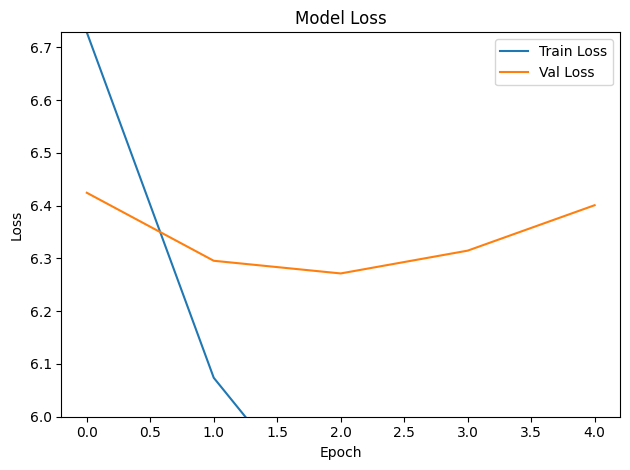

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.ylim(6, max(history.history['loss'] + history.history['val_loss']))
plt.tight_layout()
plt.show()

In [38]:
# Examining the 1st example.
x = dataset[0]
am = tf.nn.softmax(model(tf.reshape(x[:-1], (1, sentence_length))), axis = -1)
indices = map(int, x[1:])
am = tf.reshape(am, (-1, vocab_size))
probs = []
for i, idx in enumerate(indices):
    if idx == 0:
        break
    print(vocab[idx], float(am[i, idx]))
    probs.append(float(am[i, idx]))

Furthermore 0.0006774254725314677
, 0.8407228589057922
as 0.004964878316968679
an 0.038207873702049255
encouragement 1.292146771447733e-05
to 0.09295721352100372
revisionist 0.00022128724958747625
thinking 0.0004440764314495027
, 0.18843628466129303
it 0.06991051882505417
manifestly 0.00010595464118523523
is 0.08968465030193329
fair 0.000273682497208938
to 0.11655121296644211
admit 0.0009175329469144344
that 0.5329995155334473
any 0.005786418914794922
fraternity 0.00012452606461010873
has 0.030431706458330154
a 0.06462828814983368
constitutional 0.00020250241504982114
right 0.00012639196938835084
to 0.10579591989517212
refuse 0.00010817929432960227
to 0.1899857223033905
accept 0.0013566786656156182
persons 0.00013752173981629312
it 0.007104347925633192
dislikes 5.331636930350214e-05
. 0.31755274534225464


In [39]:
def softmax(logits, axis = -1):
    e = np.exp(logits)
    return e/np.sum(e, axis = axis)

def sample(n = 10, temperature = .7):
    for _ in range(n):
        x = np.zeros((sentence_length + 1)) 
        # The first token is <S> which is irrelevant to the output.
        x[0] = 1 # I could've used one-hot but making a sentence with one-hot seems weird. 
        i = 0
        choices = []
        choice = 0
        indices = list(range(vocab_size))
        
        while choice != point and i < sentence_length:
            out = np.ravel(model(x[:-1].reshape(1, sentence_length))[0, i])
            # output shape is (batch_size, sentence_length, vocab_size)
            probs = softmax(out / temperature, axis = -1)
            choice = np.random.choice(indices, p = probs)
            i = i+1
            x[i] = choice
            choices.append(choice)

        sample = " ".join(map(lambda x : vocab[x], choices))
        print(sample)

sample(25)

The sound were and the word was the continuation of the city and the presence of the soil .
But there is a good change , such , and it is also the only thing that is only to be the best ones of the fact that the spiritual tragedy can have a ` dangerous ' .
Certain criticism of the New Jersey , a showcase upon the Congo , but it was no more than by the unique officers of the ` four exercise ' , ` I won't be the basis of the creative to work that the Khrushchev would have to get the right ? ?How have in their own time ' ? ?The face ' .
As the deputy , the former Information of the ;the New York Department , I believe that the best is one of the militant commonwealth is coming up the right of the two years .
An agreement of the view of a basic community , such as a result of a Christian contact may be a new one of the coolant .
We're sure , you must have the idea of your own education ' ? We're trying to get rid of the bottom of the hall .
The radio shall be the readiness in the State to 

In [40]:
# model.save("GPT.keras")